Environment and Libraries

In [ ]:
# Note: Importing segmentation models library may give you generic_utils error on TF2.x
# When the error shows up, click the __init__.py link in the error message and change..
# keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to
# keras.utils.get_custom_objects().update(custom_objects)
!pip install -U segmentation-models
!pip install unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Note: Importing segmentation models library may give you generic_utils error on TF2.x
# When the error shows up, click the __init__.py link in the error message and change..
# keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to
# keras.utils.get_custom_objects().update(custom_objects)
# Then save the init.py file and restart runtime and run this cell


#Libraries
import cv2
import os
import glob
import warnings
import scipy.misc
import numpy as np
# # import nibabel as nib
# import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from matplotlib.widgets import Slider
from tqdm import tqdm

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout, Flatten, Dense, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.spatial.distance import directed_hausdorff


import segmentation_models as sm
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import MeanIoU
from keras.callbacks import Callback

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from tqdm import tqdm




if True:
  # Google drive
  from google.colab import drive
  drive.mount('/content/drive')

  # WD for Data
  os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks')

  # GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  # TPU
  # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  # tf.config.experimental_connect_to_cluster(resolver)
  # # This is the TPU initialization code that has to be at the beginning.
  # tf.tpu.experimental.initialize_tpu_system(resolver)
  # print("All devices: ", tf.config.list_logical_devices('TPU'))

  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

2.13.1
2.13.0
Mounted at /content/drive


SystemError: ignored

Preprocessing Data

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")
from data_augmentation import DataAugmentation

# Parameters to change according to experiment
n_classes = 5 #Number of classes for segmentation
training_augmentation = False
num_augmentations = 1
patient_index_training = [4,7,11,21]

print("Number of Patients: ", len(patient_index_training))
print("Number of Segmentation Classes: ", n_classes)
print(("Data Augmentation: {}").format(training_augmentation))
print('\n')

image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/*.nii.gz")
image_names.sort()


mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/*.nii.gz")
mask_names.sort()


image_names_train, mask_names_train = [], []
for i in range (len(image_names)):
  patient_index = int((image_names[i].split('_'))[-2])
  for x in range (len(patient_index_training)):
    if (patient_index == patient_index_training[x]):
      image_names_train.append(image_names[i])
      mask_names_train.append(mask_names[i])
image_names = image_names_train
mask_names = mask_names_train
print(image_names)
print(mask_names)
print('\n')

for image in tqdm(image_names, desc = 'Reading in Training MRI Images'):
  print(image)
  img = nib.load(image)
  img_data = img.get_fdata()
  if (image == image_names[0]):
    img_stack = img_data
  else:
    img_stack = np.concatenate((img_stack, img_data), axis = 0)


for mask in tqdm(mask_names, desc = 'Reading in Training Multi-Class Labelled Masks'):
  print(mask)
  msk = nib.load(mask)
  msk_data = msk.get_fdata()
  if (mask == mask_names[0]):
    msk_stack = msk_data
  else:
    msk_stack = np.concatenate((msk_stack, msk_data), axis = 0)
msk_stack = msk_stack.astype(np.uint8)

print('\n')
print("Total images in the original dataset are: ", len(img_stack))
print("Image data shape is: ", img_stack.shape)
print("Mask data shape is: ", msk_stack.shape)
print("Max pixel value in image is: ", img_stack.max())
print("Labels in the mask are : ", np.unique(msk_stack))


if (training_augmentation == True):
  print('\n')
  print('-'*30)
  print('Data Augmentation Starting...')
  print('-'*30)

  img_stack_aug, msk_stack_aug = DataAugmentation(img_stack, msk_stack, num_augmentations)

  img_stack_aug = np.expand_dims(img_stack_aug, axis=-1)
  msk_stack_aug = np.expand_dims(msk_stack_aug, axis=-1)

  print('Number of Augmentation per Input: ', num_augmentations)
  print('\n')
  print('Shape of Augmented Images: ', img_stack_aug.shape)
  print('Shape of Augmented Masks: ', msk_stack_aug.shape)
  print('\n')

  if True:
      img_stack = np.concatenate((img_stack, img_stack_aug), axis=0)
      msk_stack = np.concatenate((msk_stack, msk_stack_aug), axis=0)

  print('Shape of Training Image Data: ', img_stack.shape)
  print('Shape of Training Image Masks: ', msk_stack.shape)

  print('-'*30)
  print('Completed Data Augmentation Stage!')
  print('-'*30)
  print('\n')

# Channel = 3
img_stack = np.repeat(img_stack, 3, axis=3)


#Split training data
X_train, X_test, y_train, y_test = train_test_split(img_stack, msk_stack, test_size = 0.2, random_state = 42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print('Training Images Shape: ', X_train.shape)
print('Training Labels Shape: ', y_train.shape)
print('Validation Images Shape: ', X_test.shape)
print('Validation Labels Shape;: ', y_test.shape)

Number of Patients:  4
Number of Segmentation Classes:  5
Data Augmentation: False


['/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_004_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_007_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_011_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_021_0000.nii.gz']
['/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_004.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_007.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_011.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_021.nii.gz']




Reading in Training MRI Images:   0%|          | 0/4 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_004_0000.nii.gz


Reading in Training MRI Images:  25%|██▌       | 1/4 [00:06<00:18,  6.07s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_007_0000.nii.gz


Reading in Training MRI Images:  50%|█████     | 2/4 [00:10<00:09,  4.96s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_011_0000.nii.gz


Reading in Training MRI Images:  75%|███████▌  | 3/4 [00:14<00:04,  4.75s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_021_0000.nii.gz


Reading in Training Multi-Class Labelled Masks:   0%|          | 0/4 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_004.nii.gz


Reading in Training Multi-Class Labelled Masks:  25%|██▌       | 1/4 [00:01<00:05,  1.72s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_007.nii.gz


Reading in Training Multi-Class Labelled Masks:  50%|█████     | 2/4 [00:04<00:05,  2.52s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_011.nii.gz


Reading in Training Multi-Class Labelled Masks:  75%|███████▌  | 3/4 [00:07<00:02,  2.76s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_021.nii.gz


Reading in Training Multi-Class Labelled Masks: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]




Total images in the original dataset are:  2199
Image data shape is:  (2199, 256, 256, 1)
Mask data shape is:  (2199, 256, 256, 1)
Max pixel value in image is:  0.9783952832221985
Labels in the mask are :  [0 1 2 3 4]
Training Images Shape:  (1759, 256, 256, 1)
Training Labels Shape:  (1759, 256, 256, 1)
Validation Images Shape:  (440, 256, 256, 1)
Validation Labels Shape;:  (440, 256, 256, 1)


2DUNet Model

In [ ]:
# Define U-Net model
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Dice Coefficient Loss Function
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Adding a small constant to avoid division by zero
    # Convert y_true to float32
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - tf.reduce_mean(dice_coefficient)
    return loss

3D-UNet

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate

def conv_block(inputs, filters, kernel_size=(3, 3, 3), activation='relu', padding='same'):
    return Conv3D(filters, kernel_size, activation=activation, padding=padding)(inputs)

def unet_3d(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    # Middle
    conv5 = conv_block(pool4, 1024)

    # Decoder
    up6 = UpSampling3D(size=(2, 2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=-1)
    conv6 = conv_block(merge6, 512)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = conv_block(merge7, 256)

    up8 = UpSampling3D(size=(2, 2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = conv_block(merge8, 128)

    up9 = UpSampling3D(size=(2, 2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = conv_block(merge9, 64)

    # Output layer
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
input_shape = (512,512,512,1)
model = unet_3d(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 512, 1)]   0         []                            
                                                                                                  
 conv3d_6 (Conv3D)           (None, 512, 512, 512, 64)    1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling3d_4 (MaxPoolin  (None, 256, 256, 256, 64)    0         ['conv3d_6[0][0]']            
 g3D)                                                                                             
                                                                                                  
 conv3d_7 (Conv3D)           (None, 256, 256, 256, 128)   221312    ['max_pooling3d_4[0][0]'] 

2D UNet - Pytorch (nnUNet)

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout

def conv_block(inputs, filters, kernel_size=3, activation=relu):
    x = Conv2D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = activation(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = activation(x)
    return x

def downsample_block(inputs, filters, kernel_size=3, activation=relu):
    x = conv_block(inputs, filters, kernel_size, activation)
    pool = MaxPooling2D()(x)
    return x, pool

def upsample_block(inputs, skip, filters, kernel_size=3, activation=relu):
    x = Conv2DTranspose(filters, kernel_size, strides=2, padding='same')(inputs)
    x = concatenate([x, skip], axis = 3)
    x = conv_block(x, filters, kernel_size, activation)
    return x

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder (contracting path)
    enc1, pool1 = downsample_block(inputs, 32)
    enc2, pool2 = downsample_block(pool1, 64)
    enc3, pool3 = downsample_block(pool2, 128)
    enc4, pool4 = downsample_block(pool3, 256)
    enc5, _ = downsample_block(pool4, 480)

    # Bottleneck
    bottleneck = conv_block(enc5, 480)

    # Decoder (expansive path)
    dec4 = upsample_block(bottleneck, enc4, 256)
    dec3 = upsample_block(dec4, enc3, 128)
    dec2 = upsample_block(dec3, enc2, 64)
    dec1 = upsample_block(dec2, enc1, 32)

    # Output segmentation mask
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(dec1)

    model = Model(inputs, outputs)

    return model

In [ ]:
image_size = 256
image_channels = 3

unet = Unet(input_shape = (image_size, image_size, image_channels),
            filters = [16, 32, 64, 128, 256],
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

# compile & summarize the model
if model is not None:
    unet.CompileAndSummarizeModel(model = model)


model.fit(X_train,
          validation_data = valid_gen,
          steps_per_epoch = train_steps,
          validation_steps = valid_steps,
          epochs = 10)

In [ ]:
#2D U-Net Hyper-parameter Config

activation='softmax'
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()

num_classes = 5
input_shape = (256, 256, 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/2dunet_best.hdf5', monitor='val_f1-score', save_best_only=True, mode='max')
model = unet_model(input_shape, num_classes)
model.compile(optim, total_loss, metrics=metrics)

In [ ]:
activation='softmax'
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
]

num_classes = 5
input_shape = (256, 256, 1)
num_epochs = 10
batch_size = 4

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/2dunet_best.hdf5', monitor='val_f1-score', save_best_only=True, mode='max')
model = unet_model(input_shape, num_classes)
model.compile(optim, total_loss, metrics=metrics)

print(model.summary())

# Define input shape and number of classes
# input_shape = (400, 400, 1)
# num_classes = 1
# batch_size = 1
# num_epochs = 10
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# optimizer_adam = Adam(learning_rate = 1e-4)

# model = unet(input_shape, num_classes)
# model.compile(optimizer = optimizer_adam, loss = 'binary_crossentropy')
# # model.compile(optimizer = optimizer_adam, loss=dice_loss)
# checkpoint = ModelCheckpoint('model(2D, nnUNet).h5', monitor='val_loss', save_best_only=True, mode='min')
# model.fit(x=images_train, y=labels_train, batch_size=batch_size, epochs=num_epochs, validation_data=(images_val, labels_val), callbacks=[checkpoint, early_stopping])
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
AFKRun = False

history=model.fit(X_train,
          y_train_cat,
          batch_size=30,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test_cat),
          callbacks=[checkpoint])

model.save('/content/drive/MyDrive/Colab Notebooks/2dunet_final.keras')

# Performance plots
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()



if AFKRun:
  from google.colab import runtime
  runtime.unassign()

Epoch 1/10
440/440 [==============================] - ETA: 0s - loss: 0.6583 - iou_score: 0.3538 - f1-score: 0.3544

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


440/440 [==============================] - 176s 341ms/step - loss: 0.6583 - iou_score: 0.3538 - f1-score: 0.3544 - val_loss: 0.6555 - val_iou_score: 0.3481 - val_f1-score: 0.3486
Epoch 2/10
440/440 [==============================] - 144s 327ms/step - loss: 0.6516 - iou_score: 0.3518 - f1-score: 0.3522 - val_loss: 0.6555 - val_iou_score: 0.3481 - val_f1-score: 0.3486
Epoch 3/10
440/440 [==============================] - 144s 327ms/step - loss: 0.6466 - iou_score: 0.3568 - f1-score: 0.3572 - val_loss: 0.6555 - val_iou_score: 0.3481 - val_f1-score: 0.3486
Epoch 4/10
440/440 [==============================] - 144s 327ms/step - loss: 0.6440 - iou_score: 0.3595 - f1-score: 0.3600 - val_loss: 0.6555 - val_iou_score: 0.3481 - val_f1-score: 0.3486
Epoch 5/10
440/440 [==============================] - 144s 327ms/step - loss: 0.6607 - iou_score: 0.3427 - f1-score: 0.3431 - val_loss: 0.6555 - val_iou_score: 0.3481 - val_f1-score: 0.3486
Epoch 6/10
193/440 [============>.................] - ETA: 1:

KeyboardInterrupt: ignored

In [ ]:
#Set compile=False as we are not loading it for training, only for prediction.
model_fname = '/content/drive/MyDrive/Colab Notebooks/2dunet_best.hdf5'
model = load_model(model_fname, compile=False)
BACKBONE = '2D-UNet'
pred_name = 'msk_001'

n_classes = 5

print(('Fined-Tuned Model: {}').format((model_fname.split('/'))[-1]))
print('Prediction Scan Stack: ', pred_name)
print('Number of Segmentation Classes: ', n_classes)
print('\n')

img = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/{}_0000.nii.gz").format(pred_name))
# img = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTs/{}_0000.nii.gz").format(pred_name))
img_data = img.get_fdata()
X_test = np.repeat(img_data, 3, axis=3)

msk = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/{}.nii.gz").format(pred_name))
# msk = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTs/{}.nii.gz").format(pred_name))
y_test = msk.get_fdata()

print("Test Images Shape: ", X_test.shape)
print("Test Masks Shape: ", y_test.shape)
print("Test Labels: ", np.unique(y_test))
print('\n')


# Model
# preprocess input
# preprocess_input = sm.get_preprocessing(BACKBONE)
# X_test_processed = preprocess_input(X_test)
# test_masks_cat = to_categorical(y_test, num_classes=n_classes)
# y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


# Prediction
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax = np.expand_dims(y_pred_argmax, axis = -1)
print('Pred Mask Shape: ', y_pred_argmax.shape)
print("Pred Mask Labels: ", np.unique(y_pred_argmax))
print('\n')

combined_mask = y_pred_argmax.astype(np.int32)
# combined_img = nib.Nifti1Image(combined_mask, msk.affine)
combined_img = nib.Nifti1Image(combined_mask, affine=np.eye(4), dtype=np.int32)
nib.save(combined_img, ("/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/{}_pred.nii.gz").format(pred_name), dtype = np.uint8)
print('Exported Prediction Segmentation: ', ("/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/{}_pred.nii.gz").format(pred_name))
print('\n')

# from keras.metrics import MeanIoU
# Calculate Mean IoU
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
# class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
# class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,3])

def dice_coefficient(true_array, pred_array):
    true_array = np.asarray(true_array).astype(bool)
    pred_array = np.asarray(pred_array).astype(bool)

    intersection = np.logical_and(true_array, pred_array)
    dice = 2.0 * intersection.sum() / (true_array.sum() + pred_array.sum())
    return round(dice, 2)

def volume_error(y_true, y_pred):
    # mm3
    Voxel_Volume = 2.63671875

    N_true = np.count_nonzero(y_true)
    N_pred = np.count_nonzero(y_pred)

    volume_error = np.abs(N_true - N_pred) * Voxel_Volume

    return round(volume_error * 0.001, 2)


tibia_seg_data_pred = np.where(y_pred_argmax != 1, 0, 1)
femur_seg_data_pred = np.where(y_pred_argmax != 2, 0, 1)
fibula_seg_data_pred = np.where(y_pred_argmax != 3, 0, 1)
pelvis_seg_data_pred = np.where(y_pred_argmax != 4, 0, 1)

tibia_seg_data_gt = np.where(y_test != 1, 0, 1)
femur_seg_data_gt = np.where(y_test != 2, 0, 1)
fibula_seg_data_gt = np.where(y_test != 3, 0, 1)
pelvis_seg_data_gt = np.where(y_test != 4, 0, 1)

dice_score_tibia = dice_coefficient(tibia_seg_data_gt, tibia_seg_data_pred)
dice_score_femur = dice_coefficient(femur_seg_data_gt, femur_seg_data_pred)
dice_score_fibula = dice_coefficient(fibula_seg_data_gt, fibula_seg_data_pred)
dice_score_pelvis = dice_coefficient(pelvis_seg_data_gt, pelvis_seg_data_pred)

# print("Mean IoU: ", IOU_keras.result().numpy())
# print("IoU Score - Background: ", class1_IoU)
# print("IoU Score - Tibia: ", class2_IoU)
# print("IoU Score - Femur: ", class3_IoU)
# print("IoU Score - Fibula: ", class4_IoU)
# print('\n')

print('Dice Score - Tibia:', dice_score_tibia)
print('Dice Score - Femur:', dice_score_femur)
print('Dice Score - Fibula:', dice_score_fibula)
print('Dice Score - Pelvis:', dice_score_pelvis)

Fined-Tuned Model: 2dunet_best.hdf5
Prediction Scan Stack:  msk_001
Number of Segmentation Classes:  5


Test Images Shape:  (440, 256, 256, 1)
Test Masks Shape:  (517, 256, 256, 1)
Test Labels:  [0. 1. 2. 3. 4.]


14/14 [==============================] - 37s 2s/step
Pred Mask Shape:  (440, 256, 256, 1)
Pred Mask Labels:  [0]


Exported Prediction Segmentation:  /content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/msk_001_pred.nii.gz




ValueError: ignored

Prediction Mask

imgs_test size (Scans):  (214, 400, 400, 1)
imgs_test_masks size (Masks):  (214, 400, 400, 1)
------------------------------
Prediction Made Using Weights From Model: model(2D, nnUNet).h5
------------------------------
1/1 [==============================] - 0s 455ms/step
Testing Image Input Shape:  (400, 400, 1)


Dice Similarity Coefficient (DSC) Metric Value for Specified Slice:  [0.00673236]


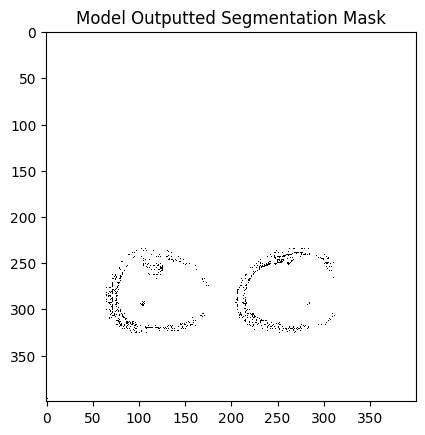

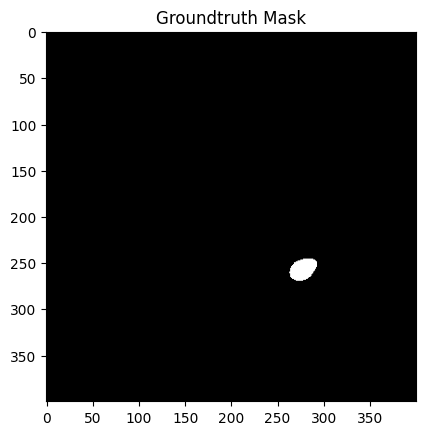

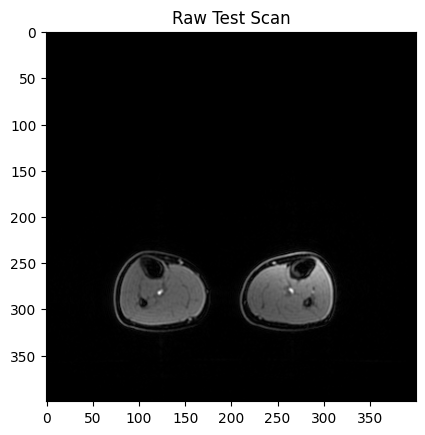

<ipython-input-5-34d36e556e56>:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_superimposed = plt.cm.get_cmap(cmap_binary)


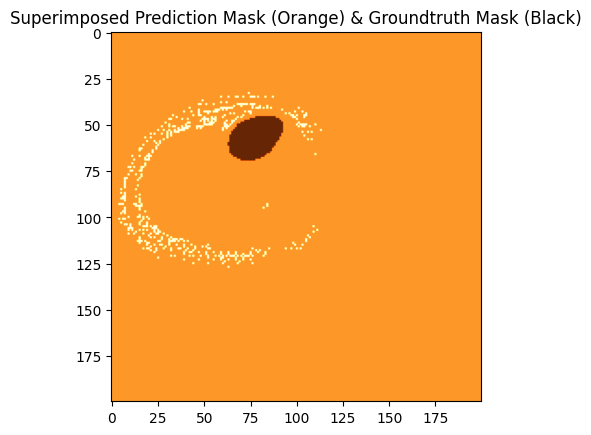

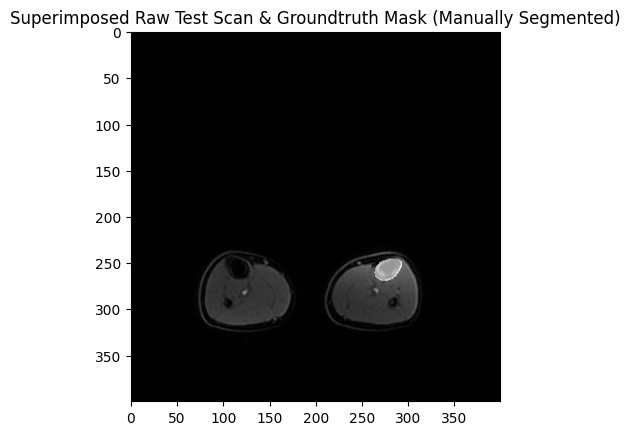

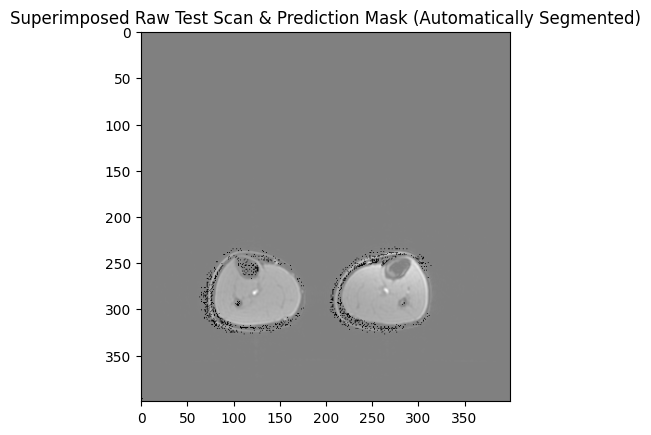

In [ ]:
# model = 'model(Baseline 125 Epoch).h5'
# model = 'model(2D UNet, 9 Patients, Tibia).h5'
# model = 'model(2D-UNet, 5 Patients, Tibia, 256x256x1).h5'
# model = 'model(2D-UNet, 3 Patients, Tibia, 400x400x1).h5'
model = 'model(2D, nnUNet).h5'
pred_img_idx = 50
MaskStack2D = False

from writeout_dataset import ReadInDatasets, ReadInDatasetNPY
# imgs_test = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)', 0, 10)
# imgs_test_masks = ReadInDatasets('/content/drive/MyDrive/Colab Notebooks/Test_Masks_Tibia(Collab Sample)', 0, 10)
imgs_test = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Test_Data_Tibia(Collab Sample)')
imgs_test_masks = ReadInDatasetNPY('/content/drive/MyDrive/Colab Notebooks/Test_Masks_Tibia(Collab Sample)')

# imgs_test_masks = (imgs_test_masks > 0).astype(np.uint8)
# testing_scans_processed = np.reshape(imgs_test, (len(imgs_test), 512, 512, 1))
# testing_masks_processed = np.reshape(imgs_test_masks, (len(imgs_test), 512, 512, 1))
print('imgs_test size (Scans): ', imgs_test.shape)
print('imgs_test_masks size (Masks): ', imgs_test_masks.shape)

def superimpose_images(image1, image2):
    # Normalize the image intensities
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)

    alpha = 0.5  # Opacity of raw scan
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

print('-'*30)
print(f'Prediction Made Using Weights From Model: {model}')
print('-'*30)

# Prediction
best_model = load_model(model)
# best_model = load_model(model, custom_objects={'dice_loss': dice_loss})
prediction = best_model.predict(np.reshape(imgs_test[pred_img_idx], (1,imgs_test.shape[1],imgs_test.shape[2],1)))
print('Testing Image Input Shape: ',imgs_test[pred_img_idx].shape)
# print('Prediction Mask Shape: ', prediction.shape)
print('\n')

# Evaluation
rounded_array  = np.round(prediction, decimals=3)
binary_pred = np.where(rounded_array != 0, 1, 0)
DSC = dice_coefficient((np.reshape(imgs_test_masks[pred_img_idx], (1,imgs_test_masks.shape[1],imgs_test_masks.shape[2],1))), binary_pred)
print('Dice Similarity Coefficient (DSC) Metric Value for Specified Slice: ', DSC)

if (MaskStack2D == True):
  DSC_stack = []
  pred_stack = []
  for i in tqdm(range(len(imgs_test_masks)), desc="Evaluating DSC on Paitent Scan Stack"):
    prediction_patient = best_model.predict(np.reshape(imgs_test[i], (1,imgs_test.shape[1],imgs_test.shape[2],1)))
    rounded_array  = np.round(prediction_patient, decimals=3)
    binary_pred_patient = np.where(rounded_array != 0, 1, 0)
    pred_stack.append(binary_pred_patient)
    DSC_patient = dice_coefficient((np.reshape(imgs_test_masks[i], (1,imgs_test_masks.shape[1],imgs_test_masks.shape[2],1))), binary_pred_patient)
    DSC_stack.append(DSC_patient)
  print('Average Dice Similarity Coefficient (DSC) Metric Value for Patient Scan Stack: ', np.mean(DSC_stack))
  np.save('ManualSegStack.npy', DSC_stack)
  print('\n')

# Visualisations
cmap_binary = 'white'
cmap_segmask = plt.cm.colors.ListedColormap(['black', cmap_binary])
bounds = [0, 0.5, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap_segmask.N)
fig, ax = plt.subplots()
ax.imshow(binary_pred[0, :, :, 0], cmap=cmap_segmask, norm=norm)
ax.axis('on')
plt.title('Model Outputted Segmentation Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(imgs_test_masks[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Groundtruth Mask')
plt.show()

fig, ax = plt.subplots()
ax.imshow(imgs_test[pred_img_idx, :, :, 0], cmap='gray')
ax.axis('on')
plt.title('Raw Test Scan')
plt.show()

cmap_binary = 'YlOrBr'
superimposed_image = superimpose_images(imgs_test_masks[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
# Define the cropping ranges
x_start, x_end = 200, 400
y_start, y_end = 200, 400
cropped_image = superimposed_image[y_start:y_end, x_start:x_end]
fig, ax = plt.subplots()
cmap_superimposed = plt.cm.get_cmap(cmap_binary)
ax.imshow(cropped_image, cmap=cmap_superimposed, vmin=0, vmax=1)
ax.axis('on')
plt.title('Superimposed Prediction Mask (Orange) & Groundtruth Mask (Black)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(imgs_test[pred_img_idx, :, :, 0], imgs_test_masks[pred_img_idx, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Groundtruth Mask (Manually Segmented)')
plt.show()

fig, ax = plt.subplots()
superimposed_image = superimpose_images(imgs_test[pred_img_idx, :, :, 0], binary_pred[0, :, :, 0])
ax.imshow(superimposed_image, cmap='gray')
ax.axis('on')
plt.title('Superimposed Raw Test Scan & Prediction Mask (Automatically Segmented)')
plt.show()



In [ ]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)

    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")

    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise

    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)

    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))

    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing

    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error

predictions_single_scan_binarized = np.reshape(predictions_single_scan_binarized,(1, 512, 512, 1))
DSC = dice_coefficient(testing_masks_processed, predictions_single_scan_binarized)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [1.43042052e-05]




In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# # Dice Coefficient Loss Function
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)

In [ ]:
# # import tensorflow as tf
# # from tensorflow import keras
# # from keras.applications import MobileNetV2
# # from keras.models import Model
# # from keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, Activation

# # from keras.applications import VGG16
# # from keras.models import Model
# # from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Activation

# # def create_unet(input_shape, num_classes):
# #     # Load pre-trained VGG16 model with 'imagenet' weights
# #     base_model = VGG16(input_shape=(input_shape[0], input_shape[1], 1), include_top=False, weights='imagenet')

# #     # Encoder (downsampling path)
# #     inputs = Input(input_shape)
# #     encoder_blocks = []
# #     x = inputs

# #     for layer in base_model.layers:
# #         if 'conv' in layer.name:
# #             x = layer(x)
# #         elif 'block' in layer.name:
# #             encoder_blocks.append(x)
# #             x = MaxPooling2D(pool_size=(2, 2))(x)

# #     # Decoder (upsampling path)
# #     encoder_blocks = encoder_blocks[::-1]  # Reverse the encoder blocks
# #     x = encoder_blocks[0]

# #     for block in encoder_blocks[1:]:
# #         x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
# #         x = concatenate([x, block], axis=-1)
# #         x = Conv2D(512, (3, 3), padding='same')(x)
# #         x = Activation('relu')(x)
# #         x = Conv2D(512, (3, 3), padding='same')(x)
# #         x = Activation('relu')(x)

# #     x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
# #     x = concatenate([x, encoder_blocks[-1]], axis=-1)
# #     x = Conv2D(256, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)
# #     x = Conv2D(256, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)

# #     x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
# #     x = concatenate([x, encoder_blocks[-2]], axis=-1)
# #     x = Conv2D(128, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)
# #     x = Conv2D(128, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)

# #     x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
# #     x = concatenate([x, encoder_blocks[-3]], axis=-1)
# #     x = Conv2D(64, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)
# #     x = Conv2D(64, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)

# #     x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
# #     x = concatenate([x, encoder_blocks[-4]], axis=-1)
# #     x = Conv2D(32, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)
# #     x = Conv2D(32, (3, 3), padding='same')(x)
# #     x = Activation('relu')(x)

# #     # Output layer
# #     outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

# #     # Create the model
# #     model = Model(inputs=inputs, outputs=outputs)

# #     return model

# # def get_unet(scale = 1, dropout_rate = 0):
# #     inputs = keras.Input((512,512,1))

# #     # Encoding Path of the UNet (32-64-128-256-512)
# #     conv1   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
# #     # conv1 = Conv2D(32*scale, 3, activation='relu', padding='same')(inputs)
# #     drop1   = Dropout(rate=dropout_rate)(conv1, training=True)
# #     max1    = MaxPooling2D((2, 2))(drop1)

# #     conv2   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
# #     drop2   = Dropout(rate=dropout_rate)(conv2, training=True)
# #     max2    = MaxPooling2D((2, 2))(drop2)

# #     conv3   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
# #     drop3   = Dropout(rate=dropout_rate)(conv3, training=True)
# #     max3    = MaxPooling2D((2, 2))(drop3)

# #     conv4   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
# #     drop4   = Dropout(rate=dropout_rate)(conv4, training=True)
# #     max4    = MaxPooling2D((2, 2))(drop4)

# #     lat     = Conv2D(512*scale, (3, 3), padding="same", activation='relu')(max4)
# #     drop5   = Dropout(rate=dropout_rate)(lat, training=True)

# #     # Decoding Path of the UNet
# #     up1     = UpSampling2D((2, 2))(drop5)
# #     concat1 = concatenate([conv4, up1], axis=-1)
# #     conv5   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(concat1)
# #     drop6   = Dropout(rate=dropout_rate)(conv5, training=True)

# #     up2     = UpSampling2D((2, 2))(drop6)
# #     concat2 = concatenate([conv3, up2], axis=-1)
# #     conv6   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat2)
# #     drop7   = Dropout(rate=dropout_rate)(conv6, training=True)

# #     up3     = UpSampling2D((2, 2))(drop7)
# #     concat3 = concatenate([conv2, up3], axis=-1)
# #     conv7   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
# #     drop8   = Dropout(rate=dropout_rate)(conv7, training=True)

# #     up4     = UpSampling2D((2, 2))(drop8)
# #     concat4 = concatenate([conv1, up4], axis=-1)
# #     conv8   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)
# #     drop9   = Dropout(rate=dropout_rate)(conv8, training=True)

# #     outputs = Conv2D(1, (1, 1), activation="softmax")(drop9)

# #     model   = Model(inputs, outputs)

# #     return model

# #   import numpy as np
# # import matplotlib.pyplot as plt
# # import tensorflow as tf
# # from tensorflow import keras
# # from keras.models import Model
# # from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
# # from keras.applications import MobileNetV2
# # from keras.optimizers import Adam

# # # Define the U-Net architecture
# # def UNet(input_shape, num_classes):
# #     base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# #     # Get the output layer from the pre-trained model
# #     base_output = base_model.get_layer('block_16_project_BN').output

# #     # Contracting pathg
# #     c1 = Conv2D(64, 3, activation='relu', padding='same')(base_output)
# #     p1 = MaxPooling2D(pool_size=(2, 2))(c1)
# #     c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
# #     p2 = MaxPooling2D(pool_size=(2, 2))(c2)
# #     c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
# #     p3 = MaxPooling2D(pool_size=(2, 2))(c3)
# #     c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
# #     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

# #     # Bottom
# #     b = Conv2D(1024, 3, activation='relu', padding='same')(p4)

# #     # Expanding path
# #     u4 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(b)
# #     u4 = concatenate([u4, c4], axis=-1)
# #     c5 = Conv2D(512, 3, activation='relu', padding='same')(u4)
# #     u3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c5)
# #     u3 = concatenate([u3, c3], axis=-1)
# #     c6 = Conv2D(256, 3, activation='relu', padding='same')(u3)
# #     u2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c6)
# #     u2 = concatenate([u2, c2], axis=-1)
# #     c7 = Conv2D(128, 3, activation='relu', padding='same')(u2)
# #     u1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c7)
# #     u1 = concatenate([u1, c1], axis=-1)
# #     c8 = Conv2D(64, 3, activation='relu', padding='same')(u1)

# #     # Output
# #     outputs = Conv2D(num_classes, 1, activation='softmax')(c8)

# #     # Create the U-Net model
# #     model = Model(inputs=base_model.input, outputs=outputs)

# #     return model

# # # Load pre-trained weights for the U-Net model
# # input_shape = (512, 512, 1)  # Replace with your input shape
# # num_classes = 2  # Replace with the number of segmentation classes
# # unet_model = UNet(input_shape, num_classes)

# # # Load the pre-trained weights
# # weights_path = 'path_to_weights.h5'  # Replace with the actual path to the weights file
# # unet_model.load_weights(weights_path)

# # # Visualize the segmentation results
# # input_image = np.random.randn(1, 512, 512, 1)  # Replace with your input image
# # predictions = unet_model.predict(input_image)

# # # Assuming predictions.shape = (1, height, width, num_classes)
# # segmentation_mask = predictions[0]
# # predicted_class = np.argmax(segmentation_mask, axis=-1)

# # # Plot the segmentation mask
# # plt.imshow(predicted_class, cmap='jet')
# # plt.colorbar()
# # plt.show()

# print('-'*30)
# print('Loading and preprocessing train data...')
# print('-'*30)

# images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
# print('Training Image Input Shape: ', images_train.shape)
# print('Training Mask Input Shape: ', labels_train.shape)
# print('Validation Image Input Shape: ', images_val.shape)
# print('Validation Mask Input Shape: ', labels_val.shape)


# print('-'*30)
# print('Creating and compiling model...')
# print('-'*30)

# # my_callbacks = [
# #     tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
# #     tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
# # ]

# input_shape = (512,512,1)
# model = unet_model(input_shape)
# # model.compile(optimizer='adam', loss='binary_crossentropy')
# model.compile(optimizer='adam', loss=dice_loss)
# checkpoint = ModelCheckpoint('DiceLoss(batch_size=4,epochs=50,train_size=50,aoi=tibia).h5', monitor='val_loss', save_best_only=True, mode='min')
# model.fit(x=images_train, y=labels_train, batch_size=4, epochs=50, validation_data=(images_val, labels_val), callbacks=[checkpoint])
# model.summary()
# # best_model = load_model('best_model.h5')

# # unet = get_unet()
# # unet.compile(optimizer=OPTIMISER, loss=LOSS)
# # unet.fit(
# #     x=images_train,
# #     y=labels_train,
# #     validation_data=(images_val, labels_val),
# #     batch_size=BATCH_SIZE,
# #     epochs=N_EPOCHS,
# #     callbacks=my_callbacks,
# #     verbose=1)

# # unet.summary()

# # unet = get_unet()
# # unet.compile(optimizer=OPTIMISER, loss=LOSS)
# # unet.load_weights('model.h5')

# # input_shape = (512, 512, 1)
# # num_classes = 2
# # num_epochs = 10
# # batch_size = 8
# # model = create_unet(input_shape, num_classes)
# # model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# # model.fit(images_train, labels_train, validation_data=(images_val, labels_val), epochs=num_epochs, batch_size=batch_size)